In [22]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import pandas as pd

In [23]:
! pwd
expr_df = pd.read_csv("../metadata/length_and_depth.csv")
expr_df = expr_df.drop("nvar", axis=1)
expr_df = expr_df.rename(columns={
    "length" : "expr_length",
    "depth" : "expr_depth"
})
expr_df

/Users/felixgao/Desktop/Year3/STA378/OptimizationParameterTuning/Julia Notebook/src


,problem,objtype,variable_nvar,expr_length,expr_depth
0,NZF1,least_squares,True,250,8
1,arglina,least_squares,True,10404,9
2,arglinb,least_squares,True,40200,8
3,arglinc,other,True,39204,7
4,argtrig,other,True,497,7
...,...,...,...,...,...
100,tridia,other,True,398,6
101,vardim,other,True,798,6
102,vibrbeam,least_squares,False,481,13
103,watson,least_squares,False,3900,12


In [24]:
complete_df = pd.read_csv("../results/complete_dataset_as_of_nov6.csv")
complete_df = complete_df[complete_df["is_init_run"] == 0]
complete_df = complete_df.rename(columns={"name" : "problem"})
df = complete_df.merge(
    expr_df,
    on = 'problem',
    how = "inner"
)
df

,status,problem,solver,mem,nvar,time,memory,num_iter,nvmops,neval_obj,...,neval_grad,init_eval_grad_time,init_eval_grad_mem,init_eval_grad_alloc,is_init_run,is_scalable,objtype,variable_nvar,expr_length,expr_depth
0,first_order,NZF1,LBFGSSolver,1,91,1.409402,0.125416,287,287,328,...,315,0.000031,0.001440,5,False,False,least_squares,True,250,8
1,first_order,NZF1,LBFGSSolver,2,91,1.407668,0.095296,199,199,223,...,216,0.000019,0.001440,5,False,False,least_squares,True,250,8
2,first_order,NZF1,LBFGSSolver,3,91,1.407882,0.103456,213,213,234,...,228,0.000016,0.001440,5,False,False,least_squares,True,250,8
3,first_order,NZF1,LBFGSSolver,4,91,1.407476,0.098352,191,191,209,...,203,0.000017,0.001440,5,False,False,least_squares,True,250,8
4,first_order,NZF1,LBFGSSolver,5,91,1.407906,0.108416,209,209,231,...,225,0.000017,0.001440,5,False,False,least_squares,True,250,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,first_order,woods,LBFGSSolver,96,1000,1.482090,3.197624,64,64,84,...,75,0.001356,0.008664,5,False,True,other,True,425,7
18822,first_order,woods,LBFGSSolver,97,1000,1.481800,3.229800,64,64,84,...,75,0.001373,0.008664,5,False,True,other,True,425,7
18823,first_order,woods,LBFGSSolver,98,1000,1.482000,3.261976,64,64,84,...,75,0.001367,0.008664,5,False,True,other,True,425,7
18824,first_order,woods,LBFGSSolver,99,1000,1.481908,3.294152,64,64,84,...,75,0.001358,0.008664,5,False,True,other,True,425,7


In [25]:
# unique instances: one row per (problem, nvar)
instances = df[["problem", "nvar"]].drop_duplicates()

# shuffle instances
instances = instances.sample(frac=1, random_state=42).reset_index(drop=True)

n = len(instances)
n_train = int(0.7 * n)
n_valid = int(0.15 * n)

train_inst = instances.iloc[:n_train]
valid_inst = instances.iloc[n_train:n_train + n_valid]
test_inst  = instances.iloc[n_train + n_valid:]

# assign rows to splits by (problem, nvar)
train_df = df.merge(train_inst, on=["problem", "nvar"], how="inner").reset_index(drop=True)
valid_df = df.merge(valid_inst, on=["problem", "nvar"], how="inner").reset_index(drop=True)
test_df  = df.merge(test_inst,  on=["problem", "nvar"], how="inner").reset_index(drop=True)
train_df

,status,problem,solver,mem,nvar,time,memory,num_iter,nvmops,neval_obj,...,neval_grad,init_eval_grad_time,init_eval_grad_mem,init_eval_grad_alloc,is_init_run,is_scalable,objtype,variable_nvar,expr_length,expr_depth
0,first_order,NZF1,LBFGSSolver,1,91,1.409402,0.125416,287,287,328,...,315,0.000031,0.001440,5,False,False,least_squares,True,250,8
1,first_order,NZF1,LBFGSSolver,2,91,1.407668,0.095296,199,199,223,...,216,0.000019,0.001440,5,False,False,least_squares,True,250,8
2,first_order,NZF1,LBFGSSolver,3,91,1.407882,0.103456,213,213,234,...,228,0.000016,0.001440,5,False,False,least_squares,True,250,8
3,first_order,NZF1,LBFGSSolver,4,91,1.407476,0.098352,191,191,209,...,203,0.000017,0.001440,5,False,False,least_squares,True,250,8
4,first_order,NZF1,LBFGSSolver,5,91,1.407906,0.108416,209,209,231,...,225,0.000017,0.001440,5,False,False,least_squares,True,250,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13021,first_order,vardim,LBFGSSolver,96,1000,29.012861,3.926536,1165,1165,6897,...,6873,0.004181,0.008664,5,False,True,other,True,798,6
13022,first_order,vardim,LBFGSSolver,97,1000,28.999431,3.958712,1165,1165,6897,...,6873,0.004192,0.008664,5,False,True,other,True,798,6
13023,first_order,vardim,LBFGSSolver,98,1000,28.868402,3.990888,1165,1165,6897,...,6873,0.004235,0.008664,5,False,True,other,True,798,6
13024,first_order,vardim,LBFGSSolver,99,1000,28.898239,4.023064,1165,1165,6897,...,6873,0.004209,0.008664,5,False,True,other,True,798,6


In [26]:
from sklearn.ensemble import RandomForestRegressor
feature_cols = ["nvar", 
                "expr_length", 
                "expr_depth", 
                "mem",
                "init_eval_obj_time", 
                "init_eval_grad_time"
                ]
target_col = "time"

X_train = train_df[feature_cols].to_numpy(dtype=float)
X_valid = valid_df[feature_cols].to_numpy(dtype=float)
X_test  = test_df[feature_cols].to_numpy(dtype=float)

t_train = np.log1p(train_df[target_col].to_numpy(dtype=float))
t_valid = np.log1p(valid_df[target_col].to_numpy(dtype=float))
t_test  = np.log1p(test_df[target_col].to_numpy(dtype=float))

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

best_rf = None
best_score = np.inf
best_params = None

for n_estimators in range(100, 200, 10):
    for max_depth in range(15, 30, 2):
        for min_leaf in [1, 2, 5]:
            rf = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_leaf,
                random_state=0,
                n_jobs=-1,
            )
            rf.fit(X_train, t_train)

            pred_valid = rf.predict(X_valid)
            mse_valid = mean_squared_error(t_valid, pred_valid)

            if mse_valid < best_score:
                best_score = mse_valid
                best_rf = rf
                best_params = (n_estimators, max_depth, min_leaf)
                print(
                        "New best:",
                        "n =", n_estimators,
                        "depth =", max_depth,
                        "min_leaf =", min_leaf,
                        "mse =", mse_valid,
                    )
            else:
                print(
                        "n =", n_estimators,
                        "depth =", max_depth,
                        "min_leaf =", min_leaf,
                        "mse =", mse_valid,
                    )

print("Best validation log1p MSE (forest):", best_score)
print("Best params (n_estimators, max_depth, min_leaf):", best_params)


New best: n = 100 depth = 15 min_leaf = 1 mse = 1.463785148450847
New best: n = 100 depth = 15 min_leaf = 2 mse = 1.323351091502925
New best: n = 100 depth = 15 min_leaf = 5 mse = 1.2733512739623538
n = 100 depth = 17 min_leaf = 1 mse = 1.4813983487520948
n = 100 depth = 17 min_leaf = 2 mse = 1.3180152379504437
n = 100 depth = 17 min_leaf = 5 mse = 1.277394273885688
n = 100 depth = 19 min_leaf = 1 mse = 1.5046911414692703
n = 100 depth = 19 min_leaf = 2 mse = 1.3156689678384768
n = 100 depth = 19 min_leaf = 5 mse = 1.2744644279170134
n = 100 depth = 21 min_leaf = 1 mse = 1.506065518078911
n = 100 depth = 21 min_leaf = 2 mse = 1.3327311506496682
New best: n = 100 depth = 21 min_leaf = 5 mse = 1.272514353657029
n = 100 depth = 23 min_leaf = 1 mse = 1.496121346107202
n = 100 depth = 23 min_leaf = 2 mse = 1.3170515372825353
n = 100 depth = 23 min_leaf = 5 mse = 1.274483582263307
n = 100 depth = 25 min_leaf = 1 mse = 1.4622057815241831
n = 100 depth = 25 min_leaf = 2 mse = 1.326099301310883

In [28]:
import statsmodels.api as sm
best_n, best_depth, best_min_leaf = best_params

X_train_full = np.vstack([X_train, X_valid])
t_train_full = np.concatenate([t_train, t_valid])
y_train_full = np.log1p(t_train_full)

final_rf = RandomForestRegressor(
    n_estimators=best_n,
    max_depth=best_depth,
    min_samples_leaf=best_min_leaf,
    random_state=0,
    n_jobs=-1,
)
final_rf.fit(X_train_full, y_train_full)

# predict on test in log1p space
pred_test_log = final_rf.predict(X_test)

# convert back to time
pred_test_time = np.expm1(pred_test_log)

test_mse = mean_squared_error(t_test, pred_test_time)
test_mae = mean_absolute_error(t_test, pred_test_time)
test_r2  = r2_score(t_test, pred_test_time)

# model = sm.fit(X_train_full, y_train_full)


print("Test MSE (time):", test_mse)
print("Test MAE (time):", test_mae)
print("Test R^2 (time):", test_r2)


Test MSE (time): 2.742394775966169
Test MAE (time): 0.8763989175547832
Test R^2 (time): -2.0357131595739872


In [29]:
best_n_estimators, best_max_depth, best_min_leaf = best_params

X_train_full = np.vstack([X_train, X_valid])
t_train_full = np.concatenate([t_train, t_valid])

final_rf = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_leaf,
    random_state=0,
    n_jobs=-1,
)
final_rf.fit(X_train_full, t_train_full)

y_pred_test = final_rf.predict(X_test)

test_mse = mean_squared_error(t_test, y_pred_test)
test_mae = mean_absolute_error(t_test, y_pred_test)
test_r2  = r2_score(t_test, y_pred_test)

print("Random forest test MSE:", test_mse)
print("Random forest test MAE:", test_mae)
print("Random forest test R^2:", test_r2)


Random forest test MSE: 2.6681807718960804
Random forest test MAE: 0.860848283976625
Random forest test R^2: -1.953561446496546


In [30]:
problem_feature_cols = [c for c in feature_cols if c != "mem"]

def choose_best_mem(model, x_problem, mem_candidates):
    preds = []
    for mem in mem_candidates:
        x = np.concatenate([x_problem, [mem]])
        preds.append((mem, model.predict(x.reshape(1, -1))[0]))
    return min(preds, key=lambda x: x[1])


In [31]:
problem_feature_cols = [c for c in feature_cols if c != "mem"]
mem_candidates_global = np.sort(train_df["mem"].unique())

In [32]:
def evaluate_mem_selector(model, df_split):
    rows = []

    # treat (problem, nvar) as one instance
    for (prob, nvar), group in df_split.groupby(["problem", "nvar"]):
        mems_available = np.sort(group["mem"].unique())
        mem_candidates = [m for m in mem_candidates_global if m in mems_available]
        if not mem_candidates:
            continue

        # build x_problem without mem
        row0 = group.iloc[0]
        x_problem = row0[problem_feature_cols].to_numpy(dtype=float)

        # this is where you use choose_best_mem
        mem_pred, _ = choose_best_mem(model, x_problem, mem_candidates)

        # true best mem and time for this instance
        best_row = group.loc[group["time"].idxmin()]
        mem_best = best_row["mem"]
        time_best = best_row["time"]

        # actual time if we use mem_pred
        time_chosen = group.loc[group["mem"] == mem_pred, "time"].min()

        rows.append(
            {
                "problem": prob,
                "nvar": nvar,
                "mem_pred": mem_pred,
                "mem_best": mem_best,
                "time_best": time_best,
                "time_chosen": time_chosen,
            }
        )

    res = pd.DataFrame(rows)
    if len(res) == 0:
        return res, float("nan"), float("nan")

    frac_exact = (res["mem_pred"] == res["mem_best"]).mean()
    avg_ratio = (res["time_chosen"] / res["time_best"]).mean()
    return res, frac_exact, avg_ratio


In [33]:
test_res_rf, frac_exact_rf, avg_ratio_rf = evaluate_mem_selector(final_rf, test_df)
print("forest exact match fraction:", frac_exact_rf)
print("forest avg time_chosen / time_best:", avg_ratio_rf)

forest exact match fraction: 0.10344827586206896
forest avg time_chosen / time_best: 1.9542456132085306


In [34]:
# random forest mem selector evaluation
# test_res_rf, frac_exact_rf, avg_ratio_rf = evaluate_mem_selector(final_rf, test_df)

ratio_rf = test_res_rf["time_chosen"] / test_res_rf["time_best"]

print("RF exact match fraction:", frac_exact_rf)
print("RF avg time_chosen / time_best:", avg_ratio_rf)
print("RF median time_chosen / time_best:", ratio_rf.median())
print("RF frac within 5%:", (ratio_rf <= 1.05).mean())
print("RF frac within 10%:", (ratio_rf <= 1.10).mean())


RF exact match fraction: 0.10344827586206896
RF avg time_chosen / time_best: 1.9542456132085306
RF median time_chosen / time_best: 1.0092898670265333
RF frac within 5%: 0.7241379310344828
RF frac within 10%: 0.7586206896551724


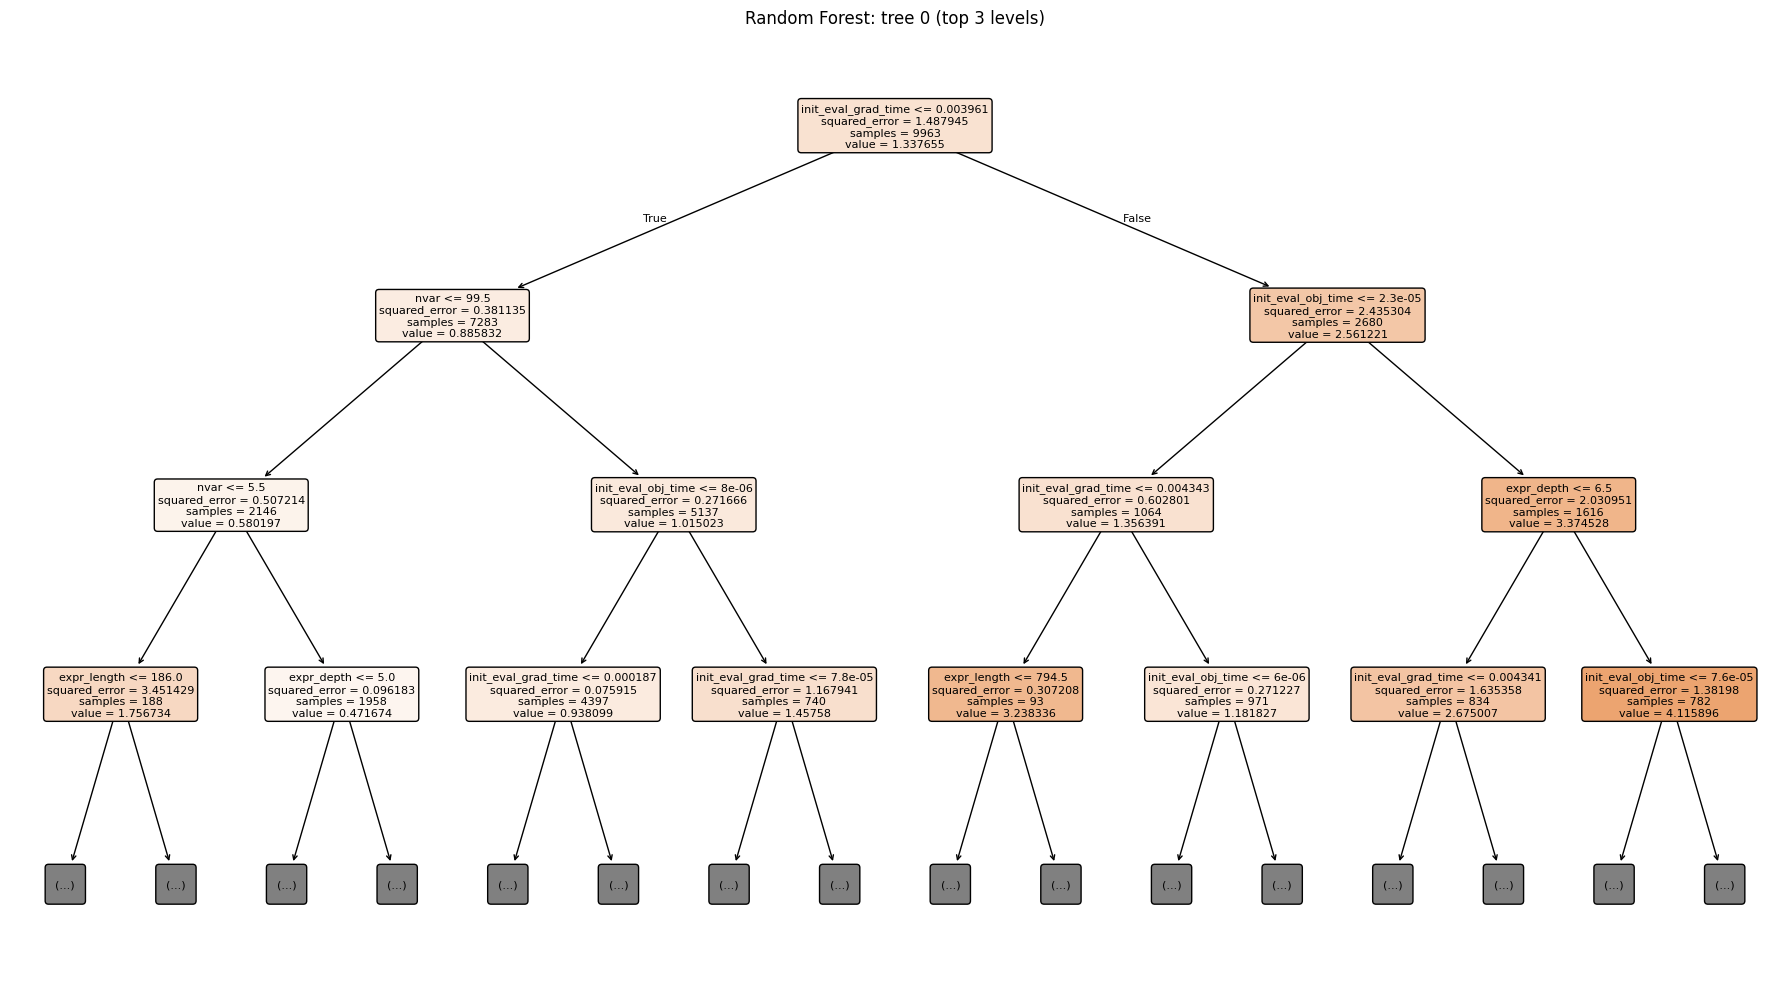

In [36]:
rf_tree0 = final_rf.estimators_[0]
from sklearn import tree

plt.figure(figsize=(18, 10))
tree.plot_tree(
    rf_tree0,
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8,
    precision=6,
)
plt.title("Random Forest: tree 0 (top 3 levels)")
plt.tight_layout()
plt.show()

In [47]:
from sklearn.tree import export_graphviz
import os

dot_data = export_graphviz(
    rf_tree0,
    max_depth=6,
    out_file=None,               # return string instead of writing directly to file
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    precision=6                  # <-- more decimal places
)


PDF written to: ../tree_plots/random_forest.pdf


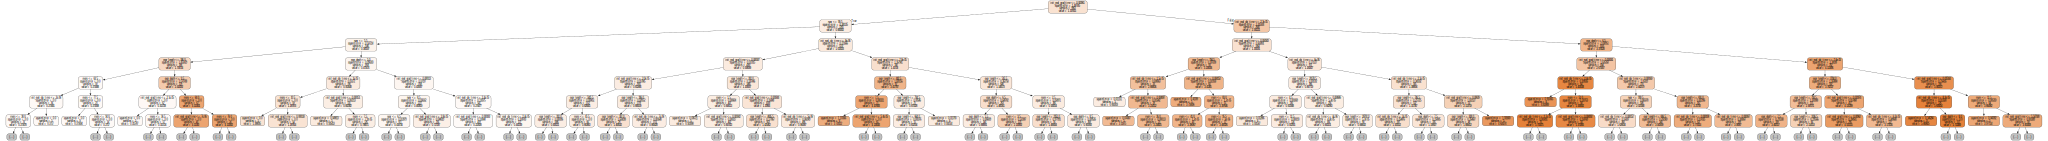

In [48]:
from graphviz import Source

os.makedirs("../tree_plots", exist_ok=True)

tree_graph = Source(dot_data)
pdf_path = tree_graph.render(
    filename="random_forest",    # base name
    directory="../tree_plots",
    format="pdf",
    cleanup=True                     # delete intermediate .dot
)
print("PDF written to:", pdf_path)
tree_graph

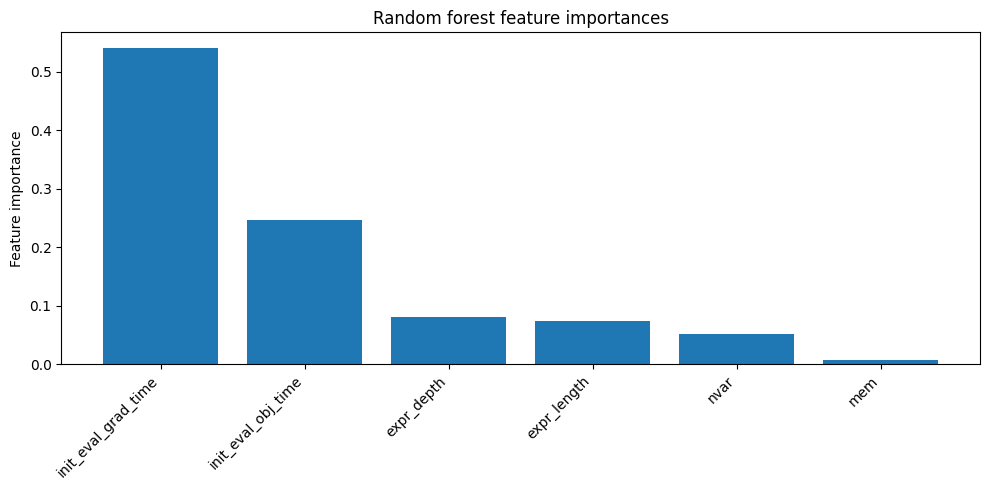

In [49]:
import numpy as np
import matplotlib.pyplot as plt

rf_importances = final_rf.feature_importances_
indices_rf = np.argsort(rf_importances)[::-1]  

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_cols)), rf_importances[indices_rf])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices_rf], rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Random forest feature importances")
plt.tight_layout()
plt.show()
